### Imports

In [46]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Load data from Bigquery

In [47]:
table = 'eth-tokens.test.clean_avg_1MM_with_balances_tokens'
label_table = 'eth-tokens.alldata.etherscan_labelcloud'

In [48]:
sql = '''
SELECT *  FROM `{}`
'''.format(table)

df = client.query(sql).to_dataframe()

In [49]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [8]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4
num_features = 15

In [50]:
pwr = PowerTransformer(standardize=False)
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)

#build pipeline
pipe = Pipeline([('power', pwr ),
                 ('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




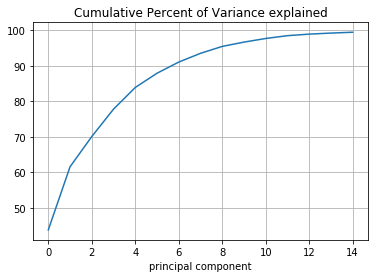

In [51]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

### Choose number of clusters with Calinski-Harabaz, Elbow Plot

In [ ]:
# #scoring metric?
# from sklearn.metrics import calinski_harabaz_score as ch_score
# clusters = [3,5,8,10,15,20,30,40,60,80]
# scores = []
# inertias = []
# for c in clusters:
#     cl_n = KMeans(c).fit(results)
#     score = ch_score(results, cl_n.labels_)
#     scores.append(score)
#     inertias.append(cl_n.inertia_)


# plt.plot(clusters, scores)
# plt.title('Calinski Harabaz Scores')

In [ ]:
# #elbow plot
# plt.plot(clusters,inertias)
# plt.title('Elbow plot')
# plt.ylabel('within cluster sum of squares')

## Optimal clusters

In [53]:
#optimal number of clusters is around 40
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# %run silhouette_plotter.py
# X=results
# range_n_clusters = [20]
# if len(newresults) <20000:
#     silhouette_plotter(X, range_n_clusters)

In [54]:
#subset results for tsne
#address mask needed for later superposition
max_size = len(results)
subset_results = []
lbls = []
address_mask = np.array([False for addr in df['address']]) 
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
        address_mask |= mask
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [88]:
#not using subset
subset_results = results
lbls = cl.labels_

In [89]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 239630 samples in 0.315s...
[t-SNE] Computed neighbors for 239630 samples in 203.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 239630
[t-SNE] Computed conditional probabilities for sample 2000 / 239630
[t-SNE] Computed conditional probabilities for sample 3000 / 239630
[t-SNE] Computed conditional probabilities for sample 4000 / 239630
[t-SNE] Computed conditional probabilities for sample 5000 / 239630
[t-SNE] Computed conditional probabilities for sample 6000 / 239630
[t-SNE] Computed conditional probabilities for sample 7000 / 239630
[t-SNE] Computed conditional probabilities for sample 8000 / 239630
[t-SNE] Computed conditional probabilities for sample 9000 / 239630
[t-SNE] Computed conditional probabilities for sample 10000 / 239630
[t-SNE] Computed conditional probabilities for sample 11000 / 239630
[t-SNE] Computed conditional probabilities for sample 12000 / 239630
[t-SNE] Computed conditional prob

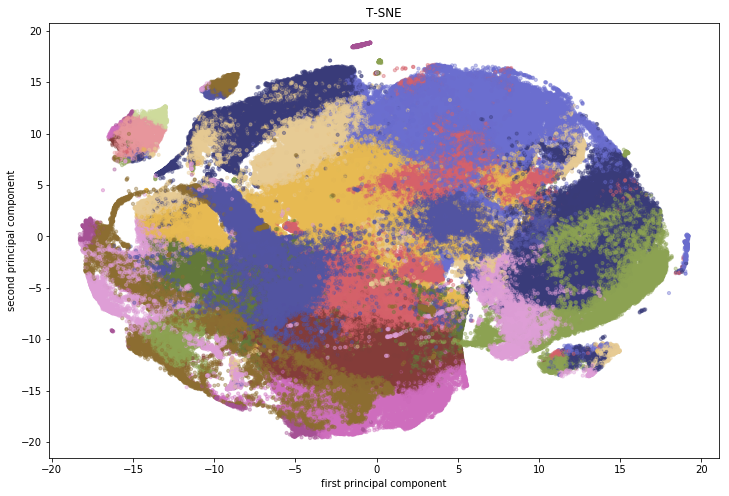

In [90]:
#color coded by cluster
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)


# leg = plt.legend()




# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

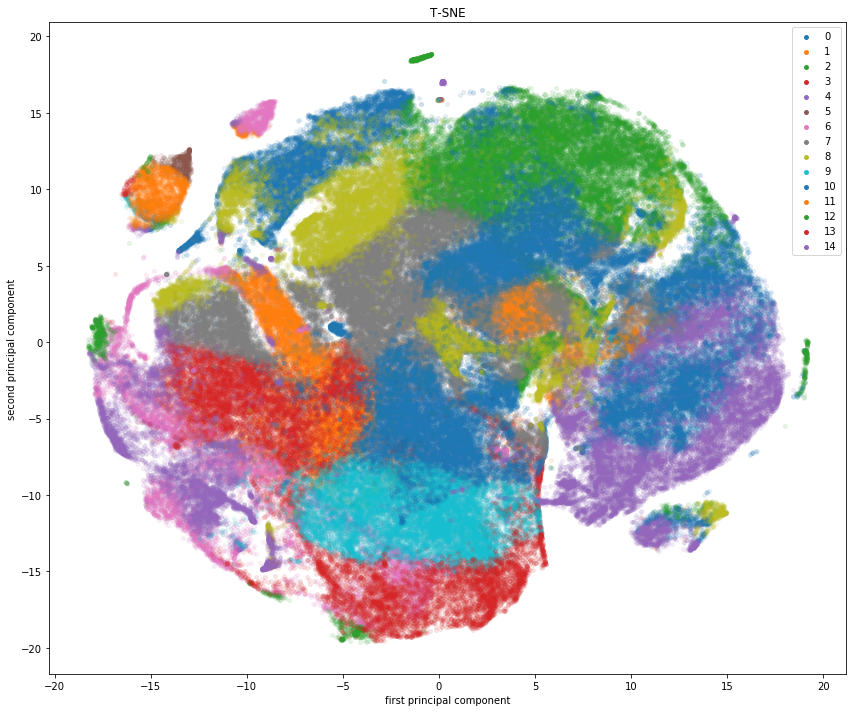

In [91]:

plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

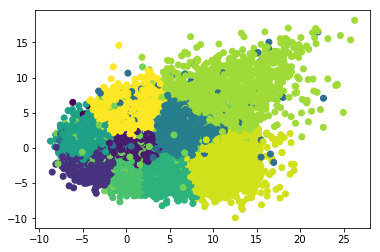

In [60]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

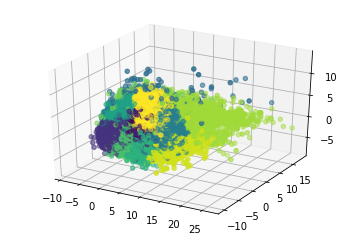

In [61]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)

## Label centroids with cluster

In [62]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = pwr.inverse_transform(scale.inverse_transform(pca.inverse_transform(c)))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [63]:
#put cluster sizes into summary dataframe
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [64]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster_size
7,6.271974,7.839710,8.155294,1.547572,4.888817e+03,795.849852,13.951523,2.276633,8.192294e+03,1063.627565,...,772.169200,0.000927,0.001841,1.078302e+06,1.338935e+06,7.785252e+05,8.522283e+05,6.085029,4.323425,32969
0,7.083308,57.235808,4.425696,0.654123,1.798893e+03,261.233266,9.951986,0.082021,3.690621e+03,66.738597,...,296.494523,0.001807,0.003058,4.112706e+05,2.698162e+05,2.161400e+06,2.239010e+06,5.142457,3.483143,32040
2,5.547701,7.885650,3.863907,0.854050,1.340366e+03,253.579151,8.014864,1.306208,3.090914e+03,398.673657,...,222.336834,0.003659,0.008444,2.890626e+06,3.626422e+06,3.748858e+06,4.412806e+06,8.269422,3.125621,30613
10,6.438276,8.023146,23.008350,4.166505,1.220025e+04,1896.881665,44.926538,6.759847,1.771016e+04,2239.718481,...,1150.422856,0.002524,0.004706,2.797741e+06,3.856908e+06,3.391776e+06,4.252392e+06,10.752211,10.982634,27074
1,21.874951,21.007509,41.652939,2.427322,2.553505e+04,1204.707910,57.104394,3.289549,3.219792e+04,1585.680299,...,2156.884981,0.000510,0.000199,1.105854e+06,1.744296e+06,8.997647e+05,1.621050e+06,21.081299,5.772408,19769
8,5.575716,8.494765,1.407043,0.287358,3.137462e+02,63.536865,4.632933,0.685724,1.655945e+03,202.275115,...,158.456567,0.004297,0.009691,1.112515e+06,1.212485e+06,4.385292e+05,4.468394e+05,5.333596,2.555178,17350
3,8.017035,10.062605,65.382727,9.404181,3.361705e+04,4317.085604,94.331680,10.872650,4.851429e+04,4969.131069,...,5730.016556,0.001105,0.001773,6.755928e+05,9.526400e+05,7.539912e+05,9.381946e+05,4.671574,11.572707,16247
9,9.751628,10.890245,278.507988,26.914964,1.140004e+05,11841.747538,473.929715,38.753653,1.180390e+05,11228.332539,...,7138.576179,0.004846,0.010709,1.880226e+06,2.953262e+06,2.193054e+06,3.297187e+06,14.699058,52.660725,16233
4,10.550892,211.089286,35.738896,3.951868,1.836766e+04,1731.046818,60.747088,0.489312,2.704156e+04,124.926888,...,1823.742440,0.004253,0.007025,1.626649e+05,1.621374e+05,2.046738e+06,2.370608e+06,9.352674,13.323622,15299
6,60.568233,91.074644,673.372729,13.775705,3.073255e+05,5164.918637,688.162619,9.727848,3.510556e+05,3850.726203,...,28419.910263,0.001876,0.004561,2.832294e+05,6.062595e+05,4.039207e+05,7.769647e+05,17.993983,13.810675,10802


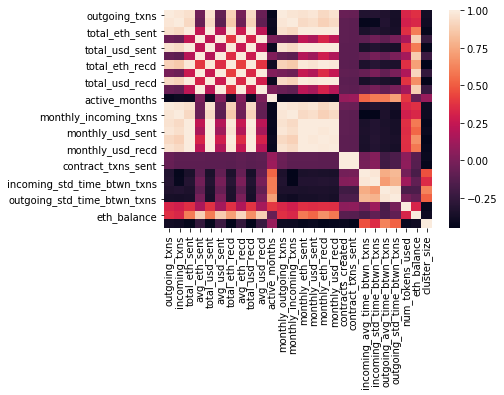

In [65]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [66]:
arr = df_summary.values

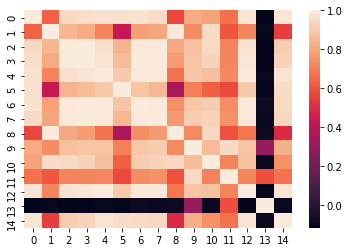

In [67]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

## Review Etherscan Labels

In [68]:
sql = '''
SELECT es.label,es.category, a.*  FROM `{}` a
INNER JOIN `{}` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''.format(table, label_table)

dflabel = client.query(sql).to_dataframe()

In [69]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [70]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [71]:
# for clust in range(cl.n_clusters):
#     print('cluster {}'.format(clust))
#     print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
#     print('total points: {}'.format(np.sum(cl.labels_==clust)))
#     print(dflabel[dflabel['cluster']==clust][['label','category']])
#     print('\n\n\n')

centralization of ownership

In [72]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

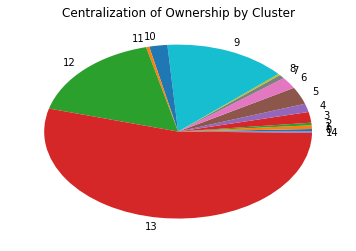

In [73]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

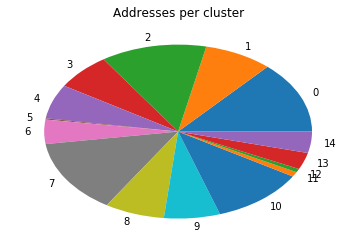

In [74]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

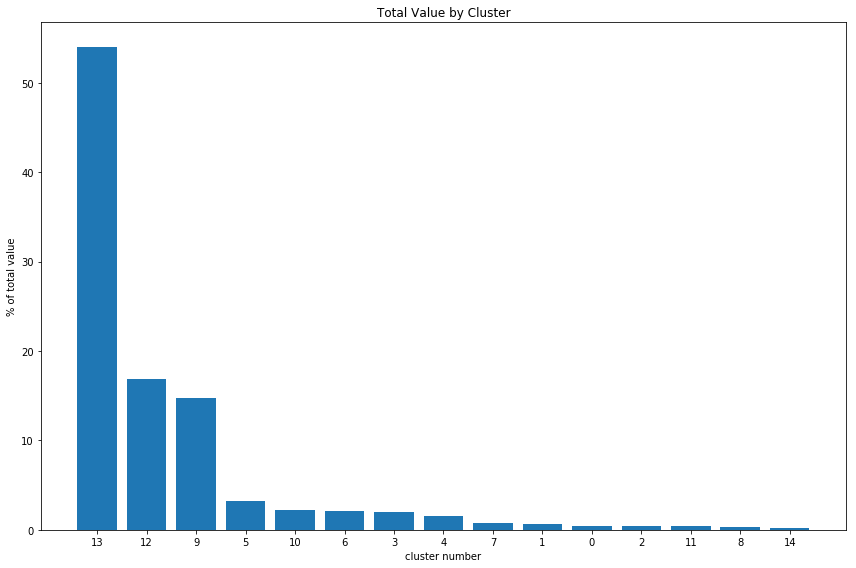

In [75]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




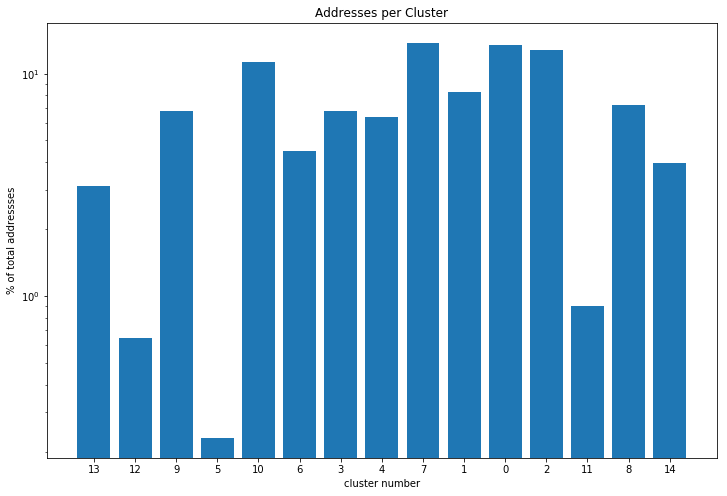

In [76]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

In [77]:


# for clust in range(cl.n_clusters):
#     cluster_data = df[cl.labels_==clust]
#     print('cluster {}'.format(clust))
#     logbins = np.logspace(0,8,16)
#     plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
#     plt.xscale('log')
#     plt.show()
    

In [78]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

In [79]:
labelcl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [labelcl.labels_[i] for i in range(len(dflabel))]

In [80]:
time_start = time.time()
tsne_label = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results_label = tsne_label.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.000s...
[t-SNE] Computed neighbors for 182 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 1.921014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.692711
[t-SNE] KL divergence after 1850 iterations: 0.364558
t-SNE done! Time elapsed: 1.1584007740020752 seconds


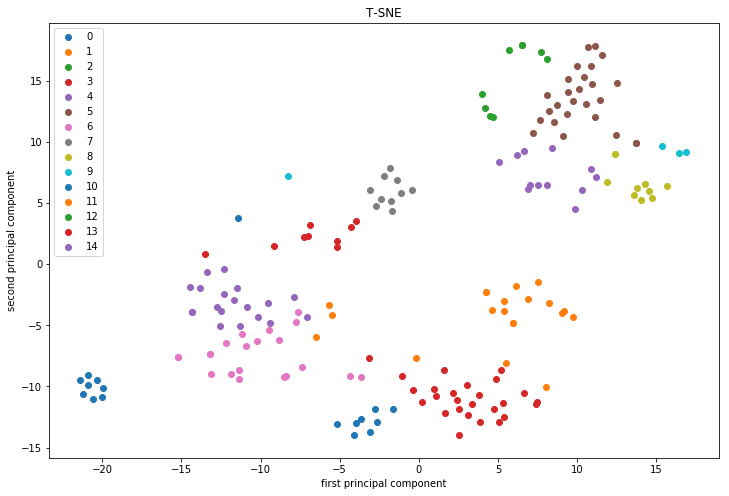

In [81]:
plt.figure(figsize=(12,8))
for c in np.unique(labelcl.labels_):
    mask = labelcl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

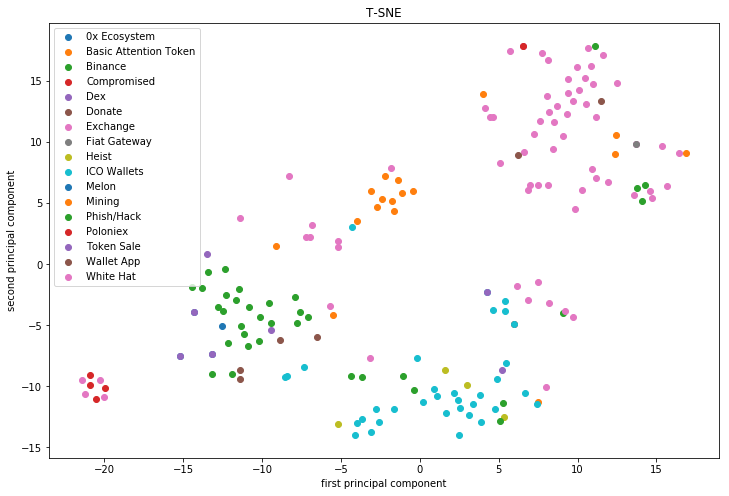

In [82]:
plt.figure(figsize=(12,8))

for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results_label[mask][:,0], tsne_results_label[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

## subset original T-SNE results
create a mask for all points that are labelled

In [92]:
labeled_addresses = dflabel['address'].values
labelmask = np.array([addr in labeled_addresses for addr in df['address'] ] )

# #labelmask for subset results!!!
# labelmask = np.array([addr in labeled_addresses for addr in df['address'][address_mask]] )

In [93]:
#helper function for category mask
def cat(addr, labeled_addresses, dflabel):
    if addr not in labeled_addresses:
        return False
    else:
        idx = int(np.where(labeled_addresses==addr)[0][0])
        return dflabel['category'][idx]

In [94]:
#setting up color map
NUM_COLORS = len(dflabel['category'].unique())
cm = plt.get_cmap('tab20')

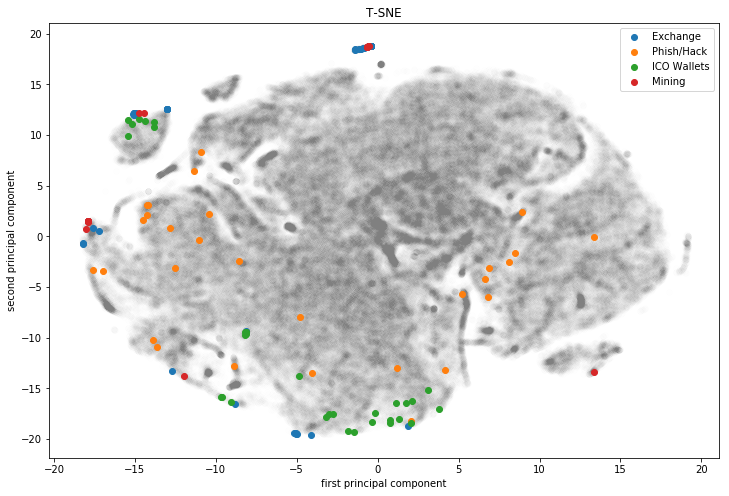

In [101]:
subset, not_subset  = tsne_results[labelmask] , tsne_results[~labelmask]
fig = plt.figure(figsize=(12,8))
#not labelled points
plt.scatter(not_subset[:,0], not_subset[:,1], c='gray', alpha=.005)

#categories
cats = np.array([cat(addr, labeled_addresses, dflabel) for addr in df['address']])#[address_mask] ]) #added address mask for all clusters

#labelled points

# ax = fig.add_subplot(111)
# ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for c in list(dflabel['category'].unique()):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    
    #category mask
    catmask = cats == c
    if np.sum(mask) >5:
        plt.scatter(tsne_results[(labelmask & catmask)][:,0], tsne_results[(labelmask & catmask)][:,1], alpha=1,label=lbl)

leg = plt.legend(bbox_to_anchor=(1, 1))
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [96]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label', 'category']])
    print('\n\n\n')

cluster 0
labelled points: 8
total points: 32040
            label  category
169  Poloniex_OMG  Exchange
170  Poloniex_OMG  Poloniex
173  Poloniex_GNT  Exchange
174  Poloniex_GNT  Poloniex
177  Poloniex_CVC  Exchange
178  Poloniex_CVC  Poloniex
179  Poloniex_REP  Exchange
180  Poloniex_REP  Poloniex




cluster 1
labelled points: 15
total points: 19769
                    label     category
1                 Bgogo_2     Exchange
11               Bitmax_2     Exchange
39              Gate.io_2     Exchange
49   MyEtherWallet_Donate       Donate
57             KuveraPool       Mining
68         CPChain_Wallet  ICO Wallets
85             BitUN.io_1     Exchange
91      LinkerCoin_Wallet  ICO Wallets
102        DMarket_Wallet  ICO Wallets
109  Compromised_Coindash  Compromised
110  Compromised_Coindash  ICO Wallets
129        Humaniq_Wallet  ICO Wallets
133    SingularDTV_Wallet  ICO Wallets
154  Substratum_TokenSale  ICO Wallets
155  Substratum_TokenSale   Token Sale




cluster 2
labelle